# Universidad Politécnica Salesiana
## Realizado por: Juan Francisco Quizhpi Fajardo ,Edwin Paul Paute
## Tema: Shape Signature

### Extracción de Imagenes

In [ ]:
#!unzip '/content/DatasetCategorias.zip' -d '/content'

### Importación de Librerias

In [ ]:
# Importar librerías principales
import cv2
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Extracción de Shape Signature

In [ ]:
def extract_shape_signature(image_path):
    # Leer la imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Mejorar el contraste de la imagen (ecualización de histograma)
    img = cv2.equalizeHist(img)

    # Binarizar la imagen utilizando Otsu
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Encontrar contornos
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Seleccionar el contorno más grande
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)

        # Calcular el centroide
        M = cv2.moments(contour)
        if M['m00'] == 0:  # Evitar división entre 0
            return None
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Calcular la firma de forma (distancia al centroide)
        signature = np.sqrt((contour[:, 0, 0] - cx)**2 + (contour[:, 0, 1] - cy)**2)
        return signature.tolist()  # Convertimos a lista para guardarlo en JSON
    return None

### Procesamiento de imágenes y guardar descriptores

In [ ]:
def process_and_save_descriptors(base_path, output_path):
    descriptors = {}
    categories = ['Turtle', 'Rat', 'Guitar', 'Glas', 'Fork']

    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            descriptors[category] = {}
            for image_name in os.listdir(category_path):
                image_path = os.path.join(category_path, image_name)
                signature = extract_shape_signature(image_path)
                if signature is not None:
                    descriptors[category][image_name] = signature

    # Guardar los descriptores en un archivo JSON
    with open(output_path, 'w') as f:
        json.dump(descriptors, f)
    print(f"Descriptores guardados en: {output_path}")

### Cargar descriptores

In [ ]:
def load_descriptors(descriptor_path):
    with open(descriptor_path, 'r') as f:
        return json.load(f)

### Interpolación de firmas

In [ ]:
def interpolate_signature(signature, target_length=256):
    return np.interp(np.linspace(0, len(signature)-1, target_length), np.arange(len(signature)), signature)

### Clasificación de imágenes

In [ ]:
def classify_image(test_signature, train_descriptors):
    test_signature_resized = interpolate_signature(test_signature, target_length=256)

    min_distance = float('inf')
    predicted_category = None

    for category, train_images in train_descriptors.items():
        for image_name, train_signature in train_images.items():
            train_signature_resized = interpolate_signature(train_signature, target_length=256)
            distance = np.linalg.norm(test_signature_resized - train_signature_resized)

            if distance < min_distance:
                min_distance = distance
                predicted_category = category

    return predicted_category

### Calcular la presición

In [ ]:
def calculate_accuracy(results):
    correct = sum(1 for _, true_label, predicted_label in results if true_label == predicted_label)
    accuracy = correct / len(results) * 100
    return accuracy

## Procesamiento del dataset de Categorias

### Eploración y procesamiento de imágenes

In [ ]:
train_path = '/content/DatasetCategorias/train'
test_path = '/content/DatasetCategorias/test'

# Procesar y guardar descriptores
process_and_save_descriptors(train_path, 'train_descriptors.json')
process_and_save_descriptors(test_path, 'test_descriptors.json')

# Cargar descriptores
train_descriptors = load_descriptors('train_descriptors.json')
test_descriptors = load_descriptors('test_descriptors.json')


Descriptores guardados en: train_descriptors.json
Descriptores guardados en: test_descriptors.json


### Clasificación de imágenes

In [ ]:
# Clasificar imágenes de prueba
results = []
for category, images in test_descriptors.items():
    for image_name, test_signature in images.items():
        predicted_category = classify_image(test_signature, train_descriptors)
        results.append((image_name, category, predicted_category))
        print(f"Imagen: {image_name} | Verdadero: {category} | Predicción: {predicted_category}")


Imagen: turtle-8.png | Verdadero: Turtle | Predicción: Turtle
Imagen: turtle-9.png | Verdadero: Turtle | Predicción: Turtle
Imagen: turtle-10.png | Verdadero: Turtle | Predicción: Guitar
Imagen: rat-10.png | Verdadero: Rat | Predicción: Rat
Imagen: rat-08.png | Verdadero: Rat | Predicción: Rat
Imagen: rat-07.png | Verdadero: Rat | Predicción: Rat
Imagen: guitar-8.png | Verdadero: Guitar | Predicción: Guitar
Imagen: guitar-9.png | Verdadero: Guitar | Predicción: Guitar
Imagen: guitar-10.png | Verdadero: Guitar | Predicción: Guitar
Imagen: Glas-8.png | Verdadero: Glas | Predicción: Glas
Imagen: Glas-10.png | Verdadero: Glas | Predicción: Glas
Imagen: Glas-9.png | Verdadero: Glas | Predicción: Glas
Imagen: fork-10.png | Verdadero: Fork | Predicción: Glas
Imagen: fork-8.png | Verdadero: Fork | Predicción: Glas
Imagen: fork-9.png | Verdadero: Fork | Predicción: Fork


## Métricas de evaluación

### Matriz de confusión para categorias

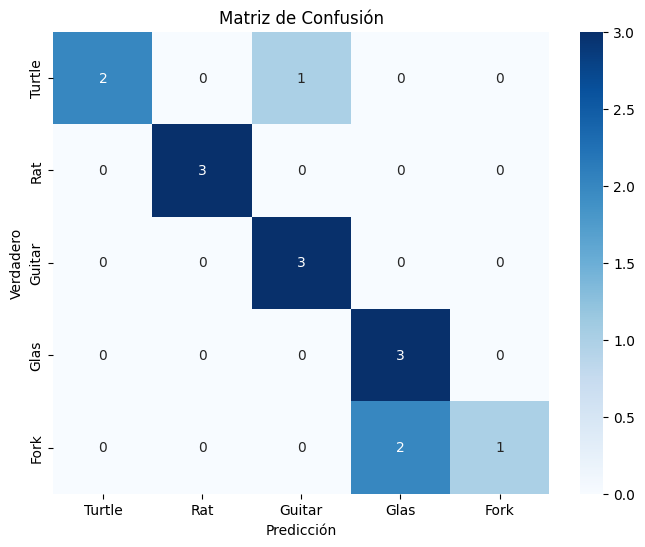

In [ ]:
true_labels = [true_label for _, true_label, _ in results]
predicted_labels = [predicted_label for _, _, predicted_label in results]
categories = list(train_descriptors.keys())

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels, labels=categories)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()


### Nivel de precisión

In [ ]:
accuracy = calculate_accuracy(results)
print(f"Precisión del modelo: {accuracy:.2f}%")

Precisión del modelo: 80.00%


### Ejemplos gráficos de confusiones

Ejemplos de imágenes mal clasificadas:
Imagen: turtle-10.png | Verdadero: Turtle | Predicción: Fork


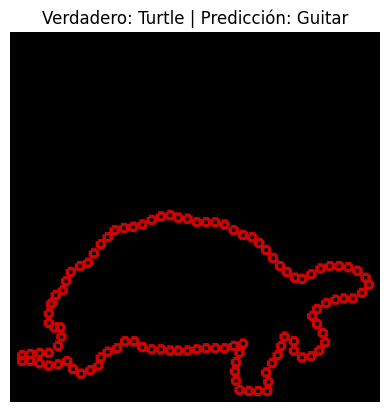

Imagen: fork-10.png | Verdadero: Fork | Predicción: Fork


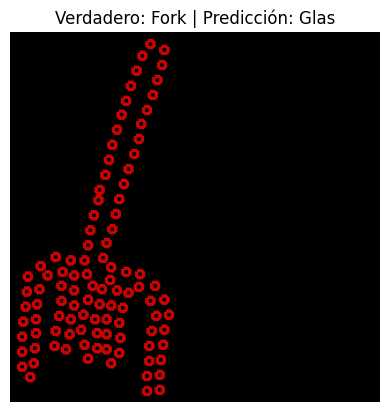

Imagen: fork-8.png | Verdadero: Fork | Predicción: Fork


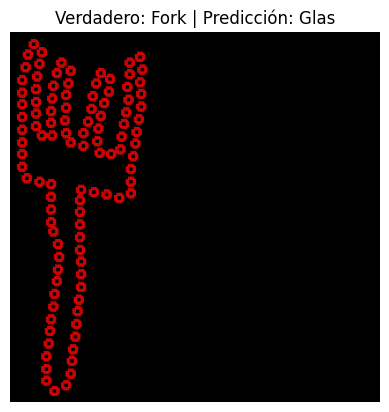

In [ ]:
confused_images = [(image_name, true_label, predicted_label) for image_name, true_label, predicted_label in results if true_label != predicted_label]

print("Ejemplos de imágenes mal clasificadas:")
for image_name, true_label, predicted_label in confused_images[:5]:  # Mostrar los primeros 5
    #print(f"Imagen: {image_name} | Verdadero: {true_label} | Predicción: {predicted_category}")
    image_path = os.path.join(test_path, true_label, image_name)
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Verdadero: {true_label} | Predicción: {predicted_label}")
    plt.axis("off")
    plt.show()
